<a href="https://colab.research.google.com/github/Ketangujare16/PRODIGY_DS_04/blob/main/Task_4_Sentiment_Analysis_Social.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install --quiet nltk wordcloud scikit-learn


In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('vader_lexicon')
%matplotlib inline
sns.set(style="whitegrid")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
from google.colab import files

uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))


Saving twitter_training.csv to twitter_training (1).csv
Uploaded files: ['twitter_training (1).csv']


In [13]:
filename = "twitter_training.csv"

df = pd.read_csv(filename, header=None, names=["Platform", "User", "OriginalSentiment", "Text"])

print("Shape:", df.shape)
df.head()


Shape: (74682, 4)


,Platform,User,OriginalSentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [14]:
# Check for nulls and basic info
print(df.columns)
print("\nMissing values per column:\n", df.isnull().sum())

# Drop rows where Text is missing
df = df.dropna(subset=['Text']).reset_index(drop=True)

# Trim whitespace in textual columns (helps matching)
df['Text'] = df['Text'].astype(str).str.strip()
df['OriginalSentiment'] = df['OriginalSentiment'].astype(str).str.strip().str.capitalize()

df.head()


Index(['Platform', 'User', 'OriginalSentiment', 'Text'], dtype='object')

Missing values per column:
 Platform               0
User                   0
OriginalSentiment      0
Text                 686
dtype: int64


,Platform,User,OriginalSentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [15]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(str(text))['compound']
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"


In [16]:
df['PredictedSentiment'] = df['Text'].apply(get_sentiment)
df[['Text','OriginalSentiment','PredictedSentiment']].head(8)


,Text,OriginalSentiment,PredictedSentiment
0,im getting on borderlands and i will murder yo...,Positive,Negative
1,I am coming to the borders and I will kill you...,Positive,Negative
2,im getting on borderlands and i will kill you ...,Positive,Negative
3,im coming on borderlands and i will murder you...,Positive,Negative
4,im getting on borderlands 2 and i will murder ...,Positive,Negative
5,im getting into borderlands and i can murder y...,Positive,Negative
6,So I spent a few hours making something for fu...,Positive,Positive
7,So I spent a couple of hours doing something f...,Positive,Positive


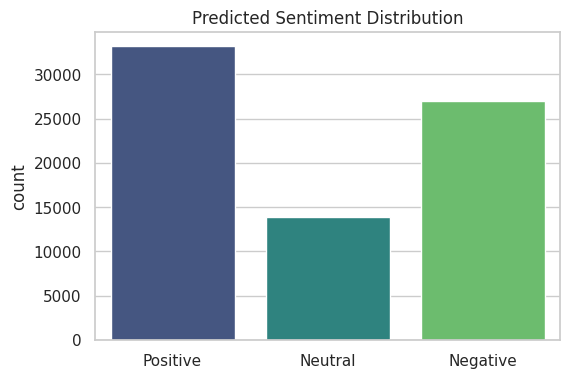

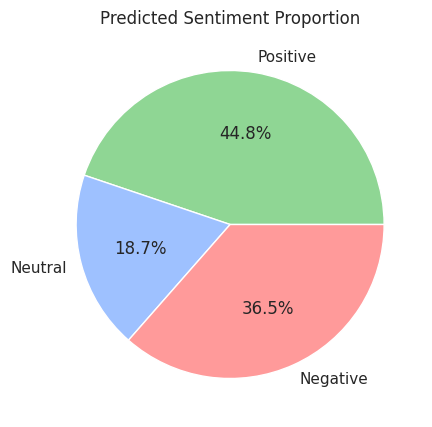

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x='PredictedSentiment', data=df, palette='viridis', order=['Positive','Neutral','Negative'])
plt.title('Predicted Sentiment Distribution')
plt.xlabel('')
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
df['PredictedSentiment'].value_counts().reindex(['Positive','Neutral','Negative']).plot.pie(
    autopct='%1.1f%%', colors=['#8fd694','#9ec1ff','#ff9a9a'])
plt.title('Predicted Sentiment Proportion')
plt.ylabel('')
plt.show()


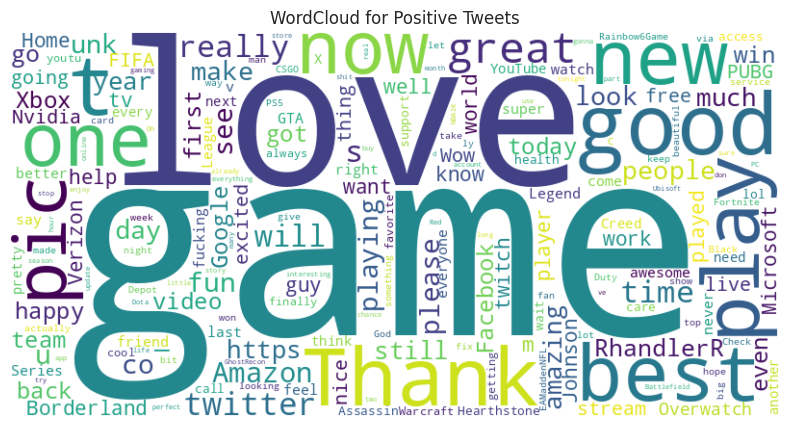

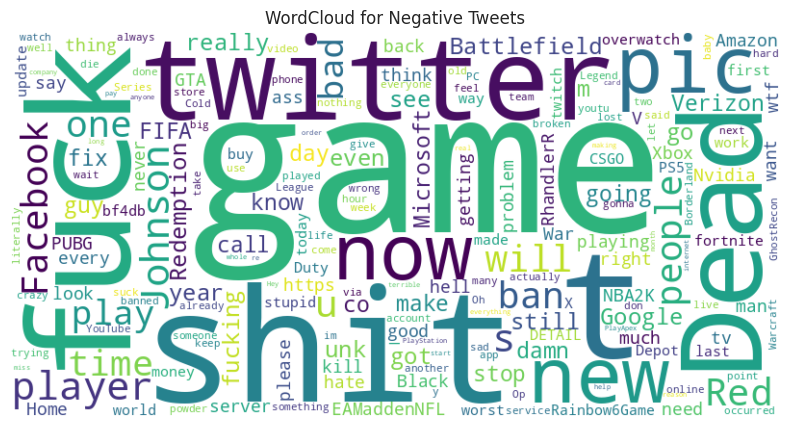

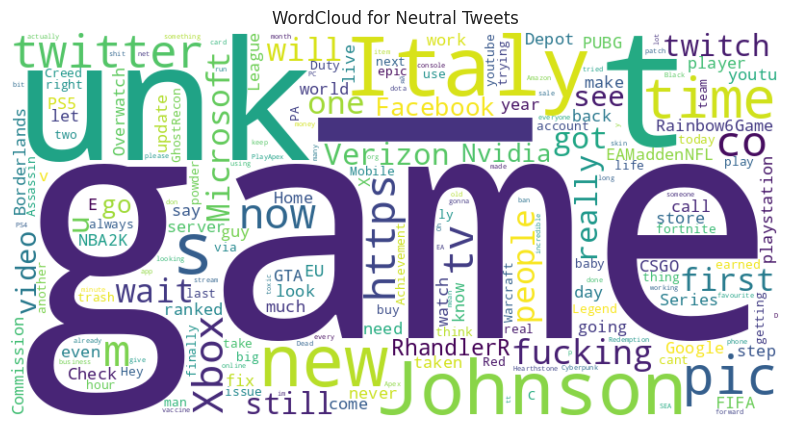

In [18]:
for sentiment in ['Positive','Negative','Neutral']:
    texts = df[df['PredictedSentiment'] == sentiment]['Text']
    if texts.empty:
        print(f"No texts for {sentiment}, skipping.")
        continue
    combined = " ".join(texts.astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(combined)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment} Tweets")
    plt.show()


Evaluation set size: 61121
Accuracy: 0.4979466958983001

Classification Report:

              precision    recall  f1-score   support

    Negative       0.57      0.57      0.57     22358
     Neutral       0.35      0.23      0.28     18108
    Positive       0.51      0.66      0.57     20655

    accuracy                           0.50     61121
   macro avg       0.47      0.49      0.47     61121
weighted avg       0.48      0.50      0.48     61121



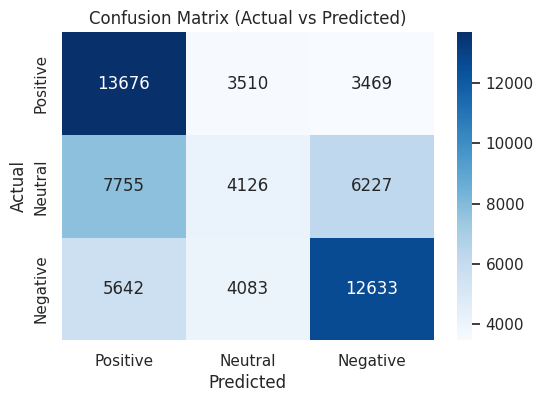

In [19]:
# Clean OriginalSentiment to expected labels if needed
df['OriginalSentiment'] = df['OriginalSentiment'].replace({
    'Positive':'Positive','positive':'Positive','POS':'Positive',
    'Negative':'Negative','negative':'Negative','NEG':'Negative',
    'Neutral':'Neutral','neutral':'Neutral','NEUTRAL':'Neutral'
}).astype(str).str.capitalize()

# Filter rows where original label is one of the three (optional)
valid_mask = df['OriginalSentiment'].isin(['Positive','Negative','Neutral'])
df_eval = df[valid_mask].copy()

print("Evaluation set size:", len(df_eval))

if len(df_eval) > 0:
    print("Accuracy:", accuracy_score(df_eval['OriginalSentiment'], df_eval['PredictedSentiment']))
    print("\nClassification Report:\n")
    print(classification_report(df_eval['OriginalSentiment'], df_eval['PredictedSentiment']))

    # Confusion matrix heatmap
    cm = confusion_matrix(df_eval['OriginalSentiment'], df_eval['PredictedSentiment'],
                          labels=['Positive','Neutral','Negative'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive','Neutral','Negative'],
                yticklabels=['Positive','Neutral','Negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Actual vs Predicted)')
    plt.show()
else:
    print("No valid OriginalSentiment labels to evaluate against.")
